# Computer Vision and Pattern Recognition - Project 3 (CNN classifier)
#### Gaia Marsich [SM3500600]

- [Introduction](#intro)
<br></br>
- [Task 1](#task1)
<br></br>
- [Task 2](#task2)
<br></br>
- [Task 3](#task3)
    - [AlexNet (1)](#alex1)
    - [AlexNet (2)](#alex2)
<br></br>
- [References](#ref)

## Introduction <a class="anchor" id="intro"></a>

This project requires the implementation of an image classifier based on convolutional neural networks. The provided dataset (from [Lazebnik et al., 2006]), contains 15 categories (office, kitchen, living room, bedroom, store, industrial, tall building, inside city, street, highway, coast, open country, mountain, forest, suburb), and is already divided in training set and test set.

First of all, let's do the imports:

In [1]:
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import random_split, DataLoader

from torchvision.datasets import ImageFolder
from torchvision import models
from torchvision.models.alexnet import AlexNet_Weights

import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.metrics import accuracy_score

from side_code import CNN
from side_code import train_test

## Task 1 <a class="anchor" id="task1"></a>

The aim of this part is to train a shallow network from scratch according to the some provided specifications.

In [2]:
# Setting a seed for reproducibility of the results

torch.manual_seed(1)

#  Load the dataset

train_path = '/Users/Gaia/Desktop/CVPR-project/CVPR-project/data/train'
test_path = '/Users/Gaia/Desktop/CVPR-project/CVPR-project/data/test'

train = ImageFolder(root=train_path, transform=train_test.transform)
dataset_test = ImageFolder(root=test_path, transform=train_test.transform)


# Split the provided training set in 85% for the actual training set and 15% for validation set

train_size = int(0.85 * len(train))
val_size = len(train) - train_size

dataset_train, dataset_val = random_split(train, [train_size, val_size])


# Create the loaders

batch_size = 32 # batch_size = 32 as required by the project
train_loader = DataLoader(dataset_train, batch_size, shuffle=True) 
val_loader = DataLoader(dataset_val, batch_size, shuffle=False)
test_loader = DataLoader(dataset_test, batch_size, shuffle=False)

Let's see how many images we have in the three sets:

In [3]:
print(f'Number of images in the train set: {len(dataset_train)}')
print(f'Number of images in the validation set: {len(dataset_val)}')
print(f'Number of images in the test set: {len(dataset_test)}')

Number of images in the train set: 1275
Number of images in the validation set: 225
Number of images in the test set: 2985


Let's instantiate a model...

In [4]:
# Instantiate a model

model = CNN.CNN1()

# Set parameters for the training

learning_rate = 0.0005
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), momentum=0.9, lr=learning_rate) # the momentum by default is 0, but I need it different from 0

...and do the training:

In [5]:
# Perform the training
model_path, loss_train, loss_val, accuracies_train, accuracies_val = train_test.train_model(
    model=model,
    EPOCHS=48,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    loss_function=loss_function,
)

EPOCH 1:
LOSS: train: 2.7081405580043794, validation: 2.7080423831939697; accuracy validation set: 10.666666666666666%

EPOCH 2:
LOSS: train: 2.7079203367233275, validation: 2.70837140083313; accuracy validation set: 7.555555555555555%

EPOCH 3:
LOSS: train: 2.7077822148799897, validation: 2.708571195602417; accuracy validation set: 7.111111111111111%

EPOCH 4:
LOSS: train: 2.7076762557029723, validation: 2.708514928817749; accuracy validation set: 5.777777777777778%

EPOCH 5:
LOSS: train: 2.7074696362018584, validation: 2.7086305618286133; accuracy validation set: 5.777777777777778%

EPOCH 6:
LOSS: train: 2.7072836220264436, validation: 2.708883047103882; accuracy validation set: 3.5555555555555554%

EPOCH 7:
LOSS: train: 2.707004129886627, validation: 2.709536075592041; accuracy validation set: 4.888888888888889%

EPOCH 8:
LOSS: train: 2.706456732749939, validation: 2.710134983062744; accuracy validation set: 5.333333333333333%

EPOCH 9:
LOSS: train: 2.705702692270279, validation: 2.

Here, the training is performed with the support of a validation set so that, during the training, the generalisation capability of the current network can be estimated. The analysis keeps going until the number of epochs that has been set is reached.
The algorithm compares the model at the current epoch with the best model previously obtained (the performances are based on the validation loss). At the end, the more recent model will be the optimal one among those that had been tested.

Let's have a look at the plot of the loss during the training:

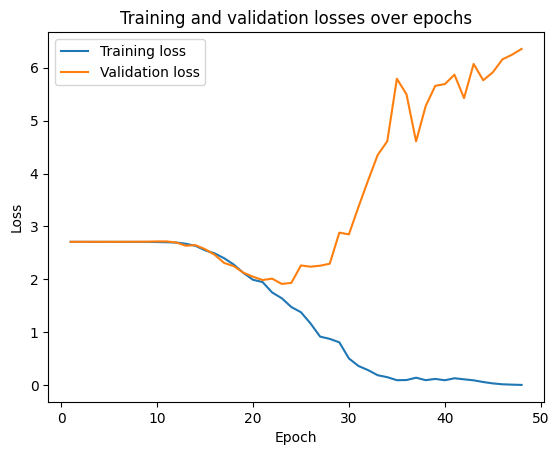

In [6]:
epochs = list(range(1, len(loss_train) + 1)) # epochs started from 0

plt.plot(epochs, loss_train, label='Training loss')
plt.plot(epochs, loss_val, label='Validation loss')
plt.title('Training and validation losses over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


As expected, since the network is trained on a specific train set over and over, the loss associated to this set keeps decreasing. On the other hand, the tests done on a separate set, the validation set, report an increase of the loss.

Here it is the plot on the accuracy:

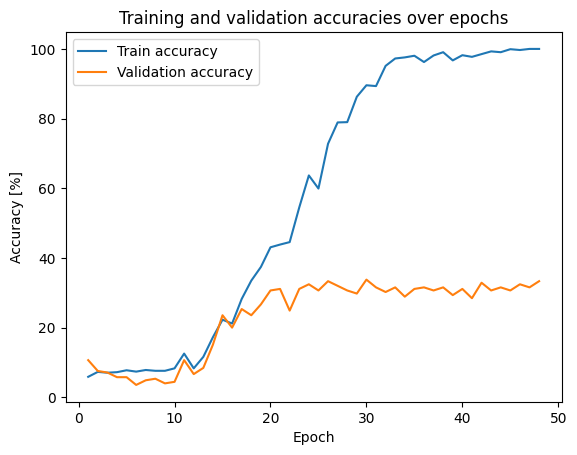

In [7]:
plt.plot(epochs, accuracies_train, label='Train accuracy')
plt.plot(epochs, accuracies_val, label='Validation accuracy')
plt.title('Training and validation accuracies over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')
plt.legend()
plt.show()

The more the network is trained the more it is expected to perform correctly. In this graph, one can observe that the accuracies associated to the train and validation sets increase.

Let's evaluate the accuracy on the test set:

Accuracy of the network on the test images: 25 %


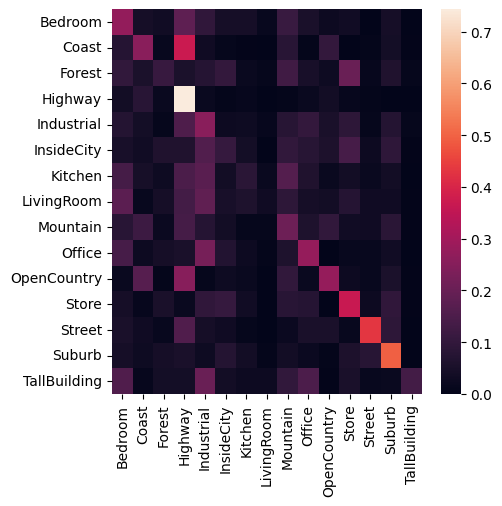

In [8]:
# Evaluate the trained network on the test set, and collect the infos for the confusion matrix

train_test.perform_test(model = model, model_path = model_path, test_loader = test_loader, dataset_test = dataset_test)

## Task 2 <a class="anchor" id="task2"></a>

The previous result can be improved using some techniques. Here, I will use:

* data augmentation: the only difference with the original version is the train/validation dataset: "new" images are added to the initial training and validation dataset. The "new" images are simply the left-to-right reflections of the original train/validation dataset.
* batch normalization
* different size of convolutional filters

In [ ]:
# Remark that from Task 1 we already have dataset_train, dataset_val and dataset_test

# Data augmentation for the train dataset

flipped_dataset_train = train_test.HorizontallyFlippedDataset(dataset_train)
data_augmentation_dataset_train = torch.utils.data.ConcatDataset([dataset_train, flipped_dataset_train])


# Create the loaders

batch_size = 32
data_augmentation_train_loader = DataLoader(data_augmentation_dataset_train, batch_size, shuffle=True) 
val_loader = DataLoader(dataset_val, batch_size, shuffle=False)
test_loader = DataLoader(dataset_test, batch_size, shuffle=False)

Now let's instantiate the model and perform the training:

In [ ]:
# Instantiate a model

model_data_augmentation = CNN.CNN2()


# Set parameters for the training

learning_rate = 0.0005
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_data_augmentation.parameters(), momentum=0.9, lr=learning_rate) # the momentum by default is 0, but I need it different from 0

# Perform the training
task2_model_path, task2_loss_train, task2_loss_val, task2_accuracies_val = train_test.train_model(model = model_data_augmentation, EPOCHS = 40, train_loader = data_augmentation_train_loader, val_loader = val_loader, optimizer = optimizer, loss_function = loss_function)

In [ ]:
# Evaluate the trained network on the test set

train_test.perform_test(model = model_data_augmentation, model_path = task2_model_path, test_loader = test_loader, dataset_test = dataset_test)

I will now investigate what happens using also:

* Adam optimizer
* dropout 

In [ ]:
# Instantiate a model

model_data_augmentation_1 = CNN.CNN3()


# Set parameters for the training

learning_rate = 0.0005
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_data_augmentation_1.parameters(), lr=learning_rate) # the momentum by default is 0, but I need it different from 0

# Perform the training
task2_1_model_path, task2_1_loss_train, task2_1_loss_val, task2_1_accuracies_val = train_test.train_model(model = model_data_augmentation_1, EPOCHS = 40, train_loader = data_augmentation_train_loader, val_loader = val_loader, optimizer = optimizer, loss_function = loss_function)

In [ ]:
# Evaluate the trained network on the test set

train_test.perform_test(model = model_data_augmentation_1, model_path = task2_1_model_path, test_loader = test_loader, dataset_test = dataset_test)

## Task 3 <a class="anchor" id="task3"></a>

In this section the transfer learning based on a pre-trained network (here, AlexNet in particular) is used.

### Alexnet (1) <a class="anchor" id="alex1"></a>

The weights of all the layers but the last fully connected layer will be frozen and the weights of the last layer will be fine-tuned.

In [ ]:
# Load the dataset; remark that AlexNet requires 3 channels as input (so, RGB)

train_path = '/Users/Gaia/Desktop/CVPR-project/CVPR-project/data/train'
test_path = '/Users/Gaia/Desktop/CVPR-project/CVPR-project/data/test'

train_ALEXNET = ImageFolder(root=train_path, transform=train_test.transform_ALEXNET)
dataset_test_ALEXNET = ImageFolder(root=test_path, transform=train_test.transform_ALEXNET)


# Split the provided training set in 85% for training set and 15% for validation set

train_size_ALEXNET = int(0.85 * len(train_ALEXNET))
val_size_ALEXNET = len(train_ALEXNET) - train_size_ALEXNET

dataset_train_ALEXNET, dataset_val_ALEXNET = random_split(train_ALEXNET, [train_size_ALEXNET, val_size_ALEXNET])

# Data augmentation

flipped_dataset_train_ALEXNET = train_test.HorizontallyFlippedDataset(dataset_train_ALEXNET)
data_augmentation_dataset_train_ALEXNET = torch.utils.data.ConcatDataset([dataset_train_ALEXNET, flipped_dataset_train_ALEXNET])


# Create the loaders

batch_size = 32
data_augmentation_train_loader_ALEXNET = DataLoader(data_augmentation_dataset_train_ALEXNET, batch_size, shuffle=True) 
val_loader_ALEXNET = DataLoader(dataset_val_ALEXNET, batch_size, shuffle=False)
test_loader_ALEXNET = DataLoader(dataset_test_ALEXNET, batch_size, shuffle=False)

In [ ]:
alexnet = models.alexnet(weights=AlexNet_Weights.DEFAULT) # weights=AlexNet_Weights.DEFAULT instead of pretrained=True as suggested by a warning

for param in alexnet.parameters(): # freeze all layers except the last fully connected layer
    param.requires_grad = False


in_features = alexnet.classifier[6].in_features # modify the last fully connected layer for your task
alexnet.classifier[6] = nn.Linear(in_features, 15)

for param in alexnet.classifier[6].parameters():
    param.requires_grad = True

loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(alexnet.parameters(), lr=0.001, momentum=0.9)


task3_model_path, task3_loss_train, task3_loss_val, task3_accuracies_val = train_test.train_model(model = alexnet, EPOCHS = 8, train_loader = data_augmentation_train_loader_ALEXNET, val_loader = val_loader_ALEXNET, optimizer = optimizer, loss_function = loss_function)

In [ ]:
train_test.perform_test(model = alexnet, model_path = task3_model_path, test_loader = test_loader_ALEXNET, dataset_test = dataset_test_ALEXNET)

### Alexnet (2) <a class="anchor" id="alex2"></a>

The pre-trained network will be employed as a feature extractor, accessing the activation of an intermediate layer (for instance, one of the fully connected layers); a multiclass linear SVM will be trained.

In [ ]:
# Load the dataset; remark that AlexNet requires 3 channels as input (so, RGB)

train_path = '/Users/Gaia/Desktop/CVPR-project/CVPR-project/data/train'
test_path = '/Users/Gaia/Desktop/CVPR-project/CVPR-project/data/test'

dataset_train_ALEXNET_2 = ImageFolder(root=train_path, transform=train_test.transform_ALEXNET)
dataset_test_ALEXNET_2 = ImageFolder(root=test_path, transform=train_test.transform_ALEXNET)


# Data augmentation

flipped_dataset_train_ALEXNET_2 = train_test.HorizontallyFlippedDataset(dataset_train_ALEXNET_2)
data_augmentation_dataset_train_ALEXNET_2 = torch.utils.data.ConcatDataset([dataset_train_ALEXNET_2, flipped_dataset_train_ALEXNET_2])


# Create the loaders

batch_size = 32
data_augmentation_train_loader_ALEXNET_2 = DataLoader(data_augmentation_dataset_train_ALEXNET_2, batch_size, shuffle=True) 
test_loader_ALEXNET_2 = DataLoader(dataset_test_ALEXNET_2, batch_size, shuffle=False)

In [ ]:
alexnet = models.alexnet(weights=AlexNet_Weights.DEFAULT)

for param in alexnet.parameters(): # freezes the parameters of the pre-trained model; these parameters will not be updated during the training process
    param.requires_grad = False

train_features, train_labels = train_test.extract(alexnet, data_augmentation_train_loader_ALEXNET_2) #TOFO: dunque davvero non serve il val?
test_features, test_labels = train_test.extract(alexnet, test_loader_ALEXNET_2)


# Train a multiclass linear SVM

SVM = svm.LinearSVC(C=1.0, max_iter=1000) #TODO: forse modificare i parametri #TODO: che approccio esattamente è stato usato? La DAG?
SVM.fit(train_features, train_labels)


# Evaluate the SVM on the test set

y_pred = SVM.predict(test_features)
accuracy = accuracy_score(test_labels, y_pred)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

## References <a class="anchor" id="ref"></a>

[1] https://dingyan89.medium.com/calculating-parameters-of-convolutional-and-fully-connected-layers-with-keras-186590df36c6